# Investigating the effects of energy threshold and uncertainties

In [15]:
import numpy as np
import stan_utility
import h5py
from matplotlib import pyplot as plt

from aeff_calculator.aeff_calculator import effective_area
from joint_model_cascades import luminosity_distance, Mpc_to_m

In [8]:
random_seed = 19920715

## Simplified toy model
Try to treat Aeff and P(Edet|E) as 1D Gaussians (or whatever is convenient) to understand and tackle full problem.

In [ ]:
# Functions
`

In [ ]:
# Sample neutrinos from power law

# Effective area effects
# Detection effects



## Full simulation down to low energies

In order to simulate a realistic scenario, simulate down to low energies, then make a cut on the detected energies.

In [4]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1.0
selection = np.where(redshift < zth)[0]
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

In [9]:
# Effective area
from scipy.interpolate import RectBivariateSpline

aeff = effective_area("nue_CC")

# refit spline (see notebook `test_aeff_implementation`)
x = np.linspace(2.99, 7.01, 200) # slightly oversample
y = np.linspace(-1.01, 1.01, 200) # slightly oversample
z = aeff.eval(x, y)
my_spline = RectBivariateSpline(x, y, z)

# Get input for spline evaluation in Stan
p = 3  # spline degree (default in RectBivariateSpline)
xknots, yknots = my_spline.get_knots()
c = my_spline.get_coeffs()

xknots = np.unique(xknots)
yknots = np.unique(yknots)
Nx = len(xknots)+p-1 
Ny = len(yknots)+p-1 
c = c.reshape(Nx, Ny)

# Maximum of the effective area, to scale 
aeff_max = max(10**aeff.aeff_vals) # m^2

... creating effective area spline for interaction nue_CC , done!


In [10]:
# Exposure integral (already includes Emin)
with h5py.File('data/precomputed_integral_1e3.h5', 'r') as f:
    alpha_grid_sim = f['alpha_grid'].value
    integral_grid_sim = f['integral_grid'].value
    
# Could try to do full problem for a simpler case

In [13]:
# Prepare simulation inputs that are defined above
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
sim_input['D'] = [luminosity_distance(z) for z in redshift[:-1]] # Mpc
sim_input['varpi'] = unit_vector

# Exposure integral interpolation grid
sim_input['Ngrid'] = len(alpha_grid_sim)
sim_input['alpha_grid'] = alpha_grid_sim
sim_input['integral_grid'] = integral_grid_sim

# Aeff Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c
sim_input['aeff_max'] = aeff_max

In [51]:
# Energies
sim_input['alpha'] = 2.0
sim_input['Emin'] = 1.0e3 # Emin_sim
Emin = 1e4 # GeV
E_scale = (Emin / sim_input['Emin'])**(1-sim_input['alpha'])
sim_input['f_E'] = 1 

# Reconstruction 
sim_input['kappa'] = 100 # ~10 deg for cascades

# Associated fraction  (derived paramaters, but easier to define this way)
total_flux = 2e4 # m^-2 yr^-1
f = 0.5

sim_input['T'] = 1 # yr
sim_input['F0'] = (1 - f) * total_flux # m^-2 yr^-1
sim_input['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) 
                                          for d in sim_input['D']])) ) # yr^-1 
print('F0:', sim_input['F0'])

F0: 10000.0


In [52]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/joint_cascade_sim_Eth.stan', 
                                 model_name = 'Eth_sim', include_paths = 'stan/')

Using cached StanModel


In [53]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

In [54]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]

selection = np.where(Edet >= Emin)[0]
Edet_sel = [Edet[_] for _ in selection]
E_sel = [E[_] for _ in selection]

print(len(Edet_sel), 'events above threshold energy out of', len(Esrc), 'total events')

892 events above threshold energy out of 1117 total events


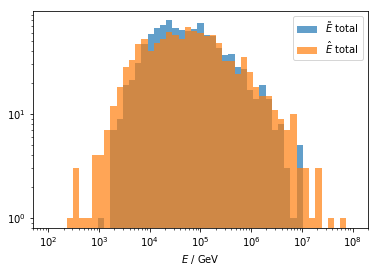

In [57]:
# Plot energies
Emin_sim = sim_input['Emin']
bins = np.logspace(np.log(Emin_sim/10), np.log(1E+5*Emin_sim), base = np.e)

fig, ax = plt.subplots()
ax.hist(E, bins=bins, label='$\\tilde{E}$ total', alpha=0.7);
ax.hist(Edet, bins=bins, label='$\hat{E}$ total', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

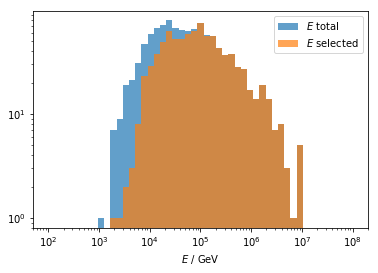

In [58]:
# Plot selected energies
fig, ax = plt.subplots()
ax.hist(E, bins=bins, label='$E$ total', alpha=0.7);
ax.hist(E_sel, bins=bins, label='$E$ selected', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

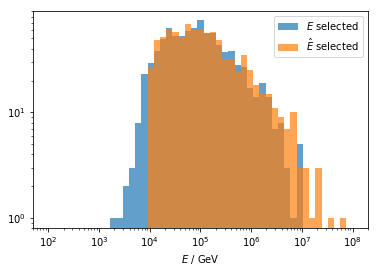

In [59]:
# Plot selected energies
fig, ax = plt.subplots()
ax.hist(E_sel, bins=bins, label='$E$ selected', alpha=0.7);
ax.hist(Edet_sel, bins=bins, label='$\hat{E}$ selected', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();